In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())

test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())

In [4]:
train_dict={}
for (data, target) in train_data:
    if  target not in train_dict:
        train_dict[ target]=[]
        train_dict[ target].append(data)
    else:
        train_dict[ target].append(data)

In [21]:
initial_train_data=[]
initial_train_label=[]
for i in range(10):
    initial_train_data.append(train_dict[i][0])
    initial_train_label.append(i)
    
print(initial_train_label)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [22]:
initial_train_data_tensor=torch.stack(initial_train_data)
initial_train_label_tensor=torch.tensor(initial_train_label)
print(initial_train_data_tensor.size())
print(initial_train_label_tensor.size())

torch.Size([10, 1, 28, 28])
torch.Size([10])


In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [95]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.final_weight=nn.init.xavier_uniform_(torch.empty(10, 10,requires_grad = True),0.1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x= torch.matmul(x,self.final_weight)
        return F.log_softmax(x,dim=-1)
    
    
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.3,
                      momentum=0.1)

In [96]:
def train():
    network.train()
    train_losses = []
    for it in range(0,1000):
        optimizer.zero_grad()
        output = network(initial_train_data_tensor)
        loss = F.nll_loss(output,initial_train_label_tensor)+torch.norm(network.final_weight,2)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    plt.plot(train_losses)
    plt.show()

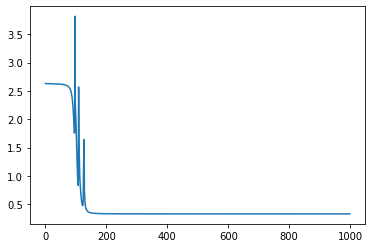

In [97]:
train()

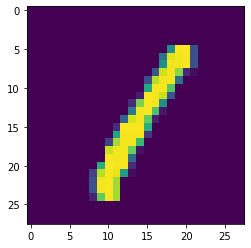

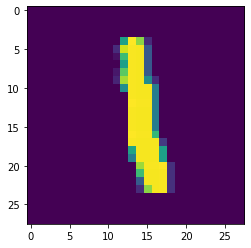

In [98]:
old_data=train_dict[1][0]
new_data=train_dict[1][1]
plt.imshow(old_data[0])
plt.show()
plt.imshow(new_data[0])
plt.show()

In [106]:
for i in train_dict[1][0:2]:
    output = torch.exp(network(i.view(1,1,28,28)))
    loss = F.nll_loss(output,torch.tensor([1]))+torch.norm(network.final_weight,2)
    loss.backward()
    print(loss)
    w_grad=network.final_weight.grad
    diag_appro=torch.diag(torch.matmul(w_grad,w_grad.t()))
    print(diag_appro)
    pred = output.data.max(1, keepdim=True)[1]
    print(pred)

tensor(-0.6724, grad_fn=<AddBackward0>)
tensor([ 37201.5156,  63839.4023,  67529.1875, 118784.1484,  75569.2812,
        137333.8125,  98246.7969,  88543.2578, 152370.8750,  74377.0156])
tensor([[1]])
tensor(0.3152, grad_fn=<AddBackward0>)
tensor([ 37279.9805,  64011.9180,  67651.6719, 119021.0859,  75685.0469,
        137584.0938,  98484.6953,  88894.4297, 152663.7656,  74568.2266])
tensor([[2]])
